In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def sigmoid(x):
    return 1/ (1 + np.exp(-x))

def d_sigmoid(x):
    s = sigmoid(x)
    return  s * (1 - s)


def ReLU(x):
    return x if x > 0 else 0

def d_ReLU(x):
    return 1 if x > 0 else 0


def tanh(x):
    return np.tanh(x)

def d_tanh(x):
    return 1 / np.cosh(x) ** 2


def linear(x):
    return x

def d_linear(x):
    return 1

def print_red(text, end): print("\033[91m {}\033[00m" .format(text), end=end)
def print_green(text, end): print("\033[92m {}\033[00m" .format(text), end=end)
def print_yellow(text, end): print("\033[93m {}\033[00m" .format(text), end=end)
def print_light_purple(text, end): print("\033[94m {}\033[00m" .format(text), end=end)
def print_purple(text, end): print("\033[95m {}\033[00m" .format(text), end=end)
def print_cyan(text, end): print("\033[96m {}\033[00m" .format(text), end=end)
def print_light_gray(text, end): print("\033[97m {}\033[00m" .format(text), end=end)
def print_black(text, end): print("\033[98m {}\033[00m" .format(text), end=end)

In [2]:
class NeuralNetwork:

    def __init__(self, input_shape, hidden_heights, Y_shape, 
                 learning_rate = 1, activation_function = sigmoid, activation_derivative = d_sigmoid):

        self.num_layers = 1 + len(hidden_heights) + 1
        self.learning_rate = learning_rate
        self.activation_function = activation_function
        self.activation_derivative = activation_derivative

        self.Weights = [0 for _ in range(0, self.num_layers - 1)]
        self.Biases  = [0 for _ in range(0, self.num_layers - 1)]

        left_shape = input_shape
        for layer in range(0, len(hidden_heights)):
            right_shape = hidden_heights[layer]
            self.Weights[layer] = np.random.randn(right_shape, left_shape)
            self.Biases[layer] = np.random.randn(right_shape, 1)
            left_shape = right_shape
        right_shape = Y_shape
        self.Weights[len(hidden_heights)] = np.random.randn(right_shape, left_shape)
        self.Biases[len(hidden_heights)] = np.random.randn(right_shape, 1)


    def create_data(self, input_cases):
        A_groups = []
        for input_case in input_cases:
            A = [0 for _ in range(0, self.num_layers)]
            A[0] = np.array([input_case]).T
            A_groups.append(A)
        return A_groups

    def train(self, input_cases, Y_groups, tol, max_iterations, get_plot = False): 
        A_groups = self.create_data(input_cases)
        A_groups, Z_groups = self.forward_prop(A_groups)
        C = 100
        count = 0
        x_vals = []
        y_vals = []
        while C > tol and count < max_iterations:
            A_groups, Z_groups, C = self.backward_prop(A_groups, Z_groups, Y_groups)
            count += 1
            x_vals.append(count)
            y_vals.append(np.log10(C))

        fig = None
        if get_plot:
            fig = plt.figure()
            plt.plot(x_vals, y_vals)
            plt.xlabel('Iterations')
            plt.ylabel(r'$\log{}$(Cost)')
            plt.title('Cost per Iterations' + ' (' + str(len(input_cases)) + ' test cases)')
            plt.grid(True)
        return C, fig


    def test(self, input_cases):
        A_groups = self.create_data(input_cases)
        A_groups, Z_groups = self.forward_prop(A_groups)
        return A_groups


    def print_results(self, A_groups, Y_groups, print_status, print_plot = False):
        count = 0
        last_layer = len(A_groups[0]) - 1
        formatter = {'float': '{: 0.2f}'.format, 'int': '{: 0.2f}'.format}
        formatter8 = {'float': '{: 0.8f}'.format, 'int': '{: 0.2f}'.format}
        for test_case_index in range(0, len(A_groups)):
            test_input = np.around(A_groups[test_case_index][0].T, decimals=2)
            rounded_result = np.around(A_groups[test_case_index][last_layer], decimals=0).T
            test_status = 'PASS' if False not in (rounded_result == Y_groups[test_case_index].T) else 'FAIL'
            count += 1 if test_status == 'PASS' else 0

            if print_status:
                if test_status == 'PASS':
                    with np.printoptions(formatter=formatter, suppress=True):
                        print_green(str(test_input), end=" : ")
                        print_green(str(rounded_result), end=" : ")
                    print_green(test_status, end=" : ")
                    with np.printoptions(formatter=formatter8, suppress=True):
                        print_green(str(A_groups[test_case_index][last_layer].T), end=' : ')
                    with np.printoptions(formatter=formatter, suppress=True):
                        print_green(str(np.array(Y_groups[test_case_index]).T), end='\n')
                else:
                    with np.printoptions(formatter=formatter, suppress=True):
                        print_red(str(test_input), end=" : ")
                        print_red(str(rounded_result), end=" : ")
                    print_red(test_status, end=" : ")
                    with np.printoptions(formatter=formatter8, suppress=True):
                        print_red(str(A_groups[test_case_index][last_layer].T), end=' : ')
                    with np.printoptions(formatter=formatter, suppress=True):
                        print_red(str(np.array(Y_groups[test_case_index]).T), end='\n')
        if print_plot:
            plt.show()

        print('PASSED: ', count, '/', len(A_groups))


    def forward_prop(self, A_groups):
        Z_groups = []
        for A in A_groups:
            Z = [0 for _ in range(0, self.num_layers - 1)]
            for layer in range(0, len(A) - 1):
                Z[layer] = np.dot(self.Weights[layer], A[layer]) + self.Biases[layer]
                A[layer + 1] = self.activation_function(Z[layer])
            Z_groups.append(Z) 
        return A_groups, Z_groups


    def backward_prop(self, A_groups, Z_groups, Y_groups):
        for layer in range(0, self.num_layers - 1):
            DCDW = 0
            DCDB = 0
            for test_case_index in range(0, len(A_groups)):
                A = A_groups[test_case_index]
                Y = Y_groups[test_case_index]
                Z = Z_groups[test_case_index]

                dzdw = A[layer]
                dzdb = np.array([[1]])
                dadz = self.activation_derivative(Z[layer])
                dcda = self.calc_dCda(A, Z, Y, layer + 1)

                dcdw = np.dot(dadz * dcda, dzdw.T)
                dcdb = np.dot(dadz * dcda, dzdb.T)
                DCDW += dcdw
                DCDB += dcdb
            self.Weights[layer] -= self.learning_rate * DCDW / len(A_groups)
            self.Biases[layer] -= self.learning_rate * DCDB / len(A_groups)
            A_groups, Z_groups = self.forward_prop(A_groups)

        C = 0
        for test_case_index in range(0, len(A_groups)):
            A = A_groups[test_case_index]
            Y = Y_groups[test_case_index]
            C += np.sum((A[self.num_layers - 1] - Y) ** 2)
        C /= len(A_groups)

        return A_groups, Z_groups, C

    
    def calc_dCda(self, A, Z, Y, layer):
        if layer == self.num_layers - 1:
            return 2 * (A[layer] - Y)
        else:
            dzda = self.Weights[layer].T
            dadz = self.activation_derivative(Z[layer])
            return np.dot(dzda, dadz * self.calc_dCda(A, Z, Y, layer + 1))


C:  0.000049999414333
 [[ 0.00]] :  [[ 1.00  0.00  0.00]] :  PASS :  [[ 0.99660067  0.00342111  0.00071300]] :  [[ 1.00  0.00  0.00]]
 [[ 1.00]] :  [[ 0.00  1.00  0.00]] :  PASS :  [[ 0.00355336  0.99396726  0.00542254]] :  [[ 0.00  1.00  0.00]]
 [[ 2.00]] :  [[ 0.00  0.00  1.00]] :  PASS :  [[ 0.00004166  0.00489530  0.99511732]] :  [[ 0.00  0.00  1.00]]


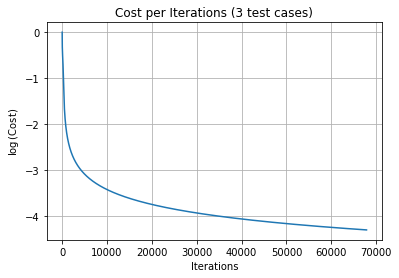

PASSED:  3 / 3

C:  0.000499995579134
 [[ 0.00]] :  [[ 1.00  0.00  0.00]] :  PASS :  [[ 0.99989132  0.00010735  0.00031771]] :  [[ 1.00  0.00  0.00]]
 [[ 0.25]] :  [[ 1.00  0.00  0.00]] :  PASS :  [[ 0.99987152  0.00012619  0.00030613]] :  [[ 1.00  0.00  0.00]]
 [[ 0.50]] :  [[ 1.00  0.00  0.00]] :  PASS :  [[ 0.99966822  0.00032001  0.00027560]] :  [[ 1.00  0.00  0.00]]
 [[ 0.75]] :  [[ 1.00  0.00  0.00]] :  PASS :  [[ 0.97680039  0.02230367  0.00030202]] :  [[ 1.00  0.00  0.00]]
 [[ 1.00]] :  [[ 0.00  1.00  0.00]] :  PASS :  [[ 0.02365862  0.97657788  0.00058658]] :  [[ 0.00  1.00  0.00]]
 [[ 1.25]] :  [[ 0.00  1.00  0.00]] :  PASS :  [[ 0.00100777  0.99889311  0.00070557]] :  [[ 0.00  1.00  0.00]]
 [[ 1.50]] :  [[ 0.00  1.00  0.00]] :  PASS :  [[ 0.00045586  0.99888353  0.00121410]] :  [[ 0.00  1.00  0.00]]
 [[ 1.75]] :  [[ 0.00  1.00  0.00]] :  PASS :  [[ 0.00014530  0.97019719  0.03275065]] :  [[ 0.00  1.00  0.00]]
 [[ 2.00]] :  [[ 0.00  0.00  1.00]] :  PASS :  [[ 0.00001704  0.03

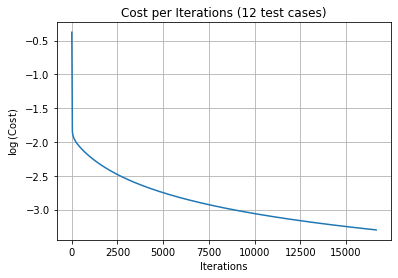

PASSED:  12 / 12

C:  0.009999852456802
PASSED:  100 / 100

PASSED:  996 / 1000



In [3]:
NN = NeuralNetwork(input_shape=1, hidden_heights=[3] ,Y_shape=3)

def create_output_data(test_cases):
    Y_groups = []
    for test_case in test_cases:
        Y = np.array([[0, 0, 0]]).T
        Y[math.floor(test_case[0])] = 1
        Y_groups.append(Y)
    return Y_groups


for test in [(3, 5e-5, True), (12, 5e-4, True), (100, 1e-2, False)]:
    test_case = np.linspace(0, 3, test[0], endpoint=False)
    input_data = []
    for case in test_case:
        input_data.append([case])
    Y_groups = create_output_data(input_data)

    C, fig = NN.train(input_data, Y_groups, test[1], 200_000, test[2])
    print('C: ', format(C, '.15f'))

    A_groups = NN.test(input_data)
    NN.print_results(A_groups, Y_groups, print_status=test[2], print_plot=test[2])
    print()

test_case = np.linspace(0, 3, 1000, endpoint=False)
input_data = []
for case in test_case:
    input_data.append([case])
Y_groups = create_output_data(input_data)

A_groups = NN.test(input_data)
NN.print_results(A_groups, Y_groups, print_status=False)
print()


C:  0.004997217768763
 [[ 0.00  0.00  0.00]] :  [[ 1.00  0.00  0.00  0.00]] :  PASS :  [[ 0.97182493  0.03073632  0.05509923  0.00004120]] :  [[ 1.00  0.00  0.00  0.00]]
 [[ 1.00  0.00  0.00]] :  [[ 0.00  1.00  0.00  0.00]] :  PASS :  [[ 0.01519646  0.96754610  0.03717395  0.00006338]] :  [[ 0.00  1.00  0.00  0.00]]
 [[ 0.00  1.00  0.00]] :  [[ 0.00  1.00  0.00  0.00]] :  PASS :  [[ 0.01517177  0.96776325  0.03715526  0.00006344]] :  [[ 0.00  1.00  0.00  0.00]]
 [[ 0.00  0.00  1.00]] :  [[ 0.00  1.00  0.00  0.00]] :  PASS :  [[ 0.01464694  0.97001575  0.03722401  0.00006424]] :  [[ 0.00  1.00  0.00  0.00]]
 [[ 1.00  1.00  0.00]] :  [[ 0.00  0.00  1.00  0.00]] :  PASS :  [[ 0.00001747  0.02669537  0.93059581  0.00212037]] :  [[ 0.00  0.00  1.00  0.00]]
 [[ 0.00  1.00  1.00]] :  [[ 0.00  0.00  1.00  0.00]] :  PASS :  [[ 0.00001753  0.02674211  0.93067235  0.00210321]] :  [[ 0.00  0.00  1.00  0.00]]
 [[ 1.00  0.00  1.00]] :  [[ 0.00  0.00  1.00  0.00]] :  PASS :  [[ 0.00001751  0.02672868

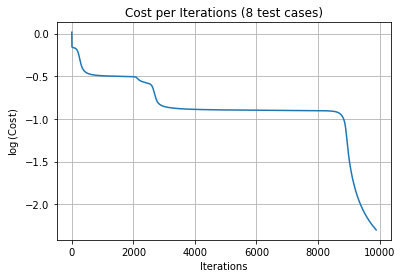

PASSED:  8 / 8

C:  0.049990070618483
PASSED:  100 / 100

 [[ 0.28  0.81  0.64]] :  [[ 0.00  0.00  1.00  0.00]] :  PASS :  [[ 0.00002595  0.02765517  0.94927162  0.00100318]] :  [[ 0.00  0.00  1.00  0.00]]
 [[ 1.09  0.10  0.23]] :  [[ 0.00  1.00  0.00  0.00]] :  PASS :  [[ 0.00127597  0.84843386  0.18840892  0.00015138]] :  [[ 0.00  1.00  0.00  0.00]]
 [[ 0.56  0.91  0.48]] :  [[ 0.00  0.00  1.00  0.00]] :  PASS :  [[ 0.00001450  0.01320915  0.96760590  0.00153121]] :  [[ 0.00  0.00  1.00  0.00]]
 [[ 0.81  0.20  0.17]] :  [[ 0.00  1.00  0.00  0.00]] :  PASS :  [[ 0.00873957  0.97340823  0.03542466  0.00006686]] :  [[ 0.00  1.00  0.00  0.00]]
 [[ 0.85  0.25  0.03]] :  [[ 0.00  1.00  0.00  0.00]] :  PASS :  [[ 0.01240124  0.97317341  0.03026855  0.00006097]] :  [[ 0.00  1.00  0.00  0.00]]
 [[ 0.28  0.67  0.60]] :  [[ 0.00  0.00  1.00  0.00]] :  PASS :  [[ 0.00010374  0.16461790  0.79488649  0.00050285]] :  [[ 0.00  0.00  1.00  0.00]]
 [[ 0.84  1.11  0.00]] :  [[ 0.00  0.00  1.00  0.00]] 

In [5]:
NN = NeuralNetwork(input_shape=3, hidden_heights=[3, 5] ,Y_shape=4)

def create_output_data(test_cases):
    Y_groups = []
    for test_case in test_cases:
        num_ones = int(np.round(np.sum(test_case)))
        Y = np.array([[0, 0, 0, 0]]).T
        Y[num_ones][0] = 1
        Y_groups.append(Y)
    return Y_groups

all_test_cases = [[[0, 0, 0], 
                   [1, 0, 0], [0, 1, 0], [0, 0, 1], 
                   [1 , 1, 0], [0, 1, 1], [1, 0, 1], 
                   [1, 1, 1]], 
                  [np.random.uniform(0, 3.5 / 3, 3) for _ in range(0, 100)]]
test_params = [(5e-3, 200_000, True), (5e-2, 200_000, False), (100, 1e-2, False)]
for test_cases_index in range(0, len(all_test_cases)):
    test_cases = all_test_cases[test_cases_index]
    test_param = test_params[test_cases_index]

    Y_groups = create_output_data(test_cases)
    C, fig = NN.train(test_cases, Y_groups, test_param[0], test_param[1], test_param[2])
    print('C: ', format(C, '.15f'))
    A_groups = NN.test(test_cases)
    NN.print_results(A_groups, Y_groups, print_status=test_param[2], print_plot=test_param[2])
    print()


test_cases = [np.random.uniform(0, 3.5 / 3, 3) for _ in range(0, 15)]
Y_groups = create_output_data(test_cases)
A_groups = NN.test(test_cases)
NN.print_results(A_groups, Y_groups, print_status=True)
print()
